# Treinamento - Dataset 1

## Imports

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

from tensorflow.keras.utils import normalize

from tensorflow.keras.layers import Input,LeakyReLU

from tensorflow.keras.initializers import he_normal

import gc

## Desabilitando uso da GPU - apenas no caso da instalação do tensorflow com suporte a GPU

* O uso da GPU traz banefícios de desempenho para modelos médios e grandes apenas

In [2]:
# force CPU (make CPU visible)
cpus = tf.config.experimental.list_physical_devices('CPU')
print(cpus)
tf.config.set_visible_devices([], 'GPU')  # hide the GPU
tf.config.set_visible_devices(cpus[0], 'CPU') # unhide potentially hidden CPU
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Leitura dos dados

In [3]:
dataPath = r'D:\14--OneDrive\OneDrive\ML-SEA-2021\Rede_Teste_2'
#npzFname = 'training_data_sw_ar_clean.npz'
npzFname = 'training_data_sw_ar_raw.npz'

npz = np.load(os.path.join(dataPath, npzFname))

X_TRAIN = npz['X_TRAIN']
Y_TRAIN = npz['Y_TRAIN']

X_TEST = npz['X_TEST']
Y_TEST = npz['Y_TEST']

m_train = X_TRAIN.shape[0]
m_test = X_TEST.shape[0]
n_inp = X_TRAIN.shape[1]
n_out = Y_TRAIN.shape[1]
print('{:>30}{:8}'.format('Number of TRAINING samples:', m_train))
print('{:>30}{:8}'.format('Number of TEST samples:', m_test))
print('{:>30}{:8}'.format('Number of features:', n_inp))
print('{:>30}{:8}'.format('Number of labels:', n_out))

   Number of TRAINING samples:     950
       Number of TEST samples:     950
           Number of features:       2
             Number of labels:       1


## Normalização dos dados



### Definição da classe com método de normalização
É mais conveniente se utilizar uma classe pois sua instância guardará as informação da normalização 
que serão utilizadas no final do processo para desnormalizar a saída da rede

In [4]:
class normalizer:
    
    def __init__(self):       
        pass
    
    def set_norm(self, A, axis=0):
        self.mean = np.mean(A, axis=axis)
        self.std = np.std(A, axis=axis)
        
    def normalize(self, A):
        return (A - self.mean) / self.std
    
    def denormalize(self, A):
        return A * self.std + self.mean

### Criação e setup dos objetos normalizadores

In [5]:
inp_normalizer = normalizer()
inp_normalizer.set_norm(X_TRAIN)

out_normalizer = normalizer()
out_normalizer.set_norm(Y_TRAIN)

X_TRAIN_norm = inp_normalizer.normalize(X_TRAIN)
Y_TRAIN_norm = out_normalizer.normalize(Y_TRAIN)
X_TEST_norm = inp_normalizer.normalize(X_TEST)
Y_TEST_norm = out_normalizer.normalize(Y_TEST)

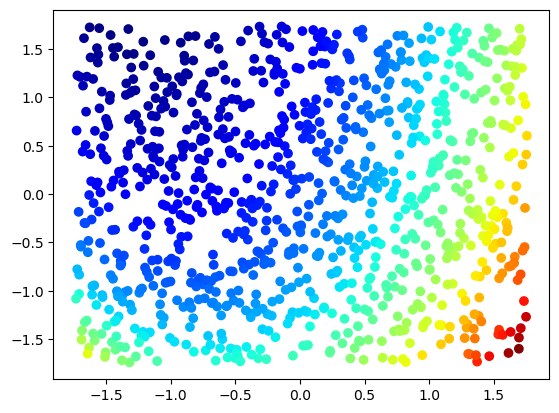

In [6]:
import matplotlib.pyplot as plt
plt.scatter(X_TRAIN_norm[:,0], X_TRAIN_norm[:,1], c=Y_TRAIN_norm[:,0], cmap='jet')
plt.show()

## Função ára montagem do modelo / gráfico do Tensorflow

Inclui setup do otimizador, métricas e compilação dos modelos

In [7]:
def get_nn(layers, lr, n_inp=n_inp, n_out=n_out):

    inp = Input(shape=(n_inp,))

    n_prev = n_inp

    x = inp



    for n_layer in layers:
        x = Dense(n_layer, input_dim=n_prev, use_bias = True, 
                  kernel_initializer=he_normal(seed=None), bias_initializer='zeros')(x)
        x = Activation('tanh')(x)
        n_prev = n_layer

    x = Dense(n_out, input_dim=n_prev, use_bias = True, 
              kernel_initializer=he_normal(seed=None), bias_initializer='zeros')(x)
    output = Activation('linear')(x)

    adam = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1.e-8, decay=0.1, amsgrad=False)

    metric1 = metrics.MeanSquaredError(name='mse', dtype=None)
    metric2 = metrics.MeanAbsolutePercentageError(name='mape', dtype=None)

    model = Model(inp,output)

    model.compile(loss='mse',
                  optimizer=adam,
                  metrics = [metric2])
    
    return model

### Setup do otimizador, métricas e compilação dos modelos

In [8]:
adam = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1.e-8, decay=0.1, amsgrad=False)

metric1 = metrics.MeanSquaredError(name='mse', dtype=None)
metric2 = metrics.MeanAbsolutePercentageError(name='mape', dtype=None)

model = Model(inp,output)

model.compile(loss='mse',
              optimizer=adam,
              metrics = [metric2])

###  Treinamento e busca de hiperparâmetros "ótimos"

In [9]:
layers_list = [[16]*3,
               [32]*3,
               [64]*3,
               [16]*5,
               [32]*5,
               [64]*5,
               [16]*8,
               [32]*8,
               [64]*8]

lr_list = [1.0, 0.1, 0.01]
for layers in layers_list:
    for lr in lr_list:
        nn = get_nn(layers, lr)
        nn.fit(X_TRAIN_norm, Y_TRAIN_norm,
                  validation_data = (X_TEST_norm, Y_TEST_norm),
                  epochs=40,
                  batch_size=32,
                  shuffle=True,
                  verbose = 0)
        score = nn.evaluate(x=X_TEST_norm, y=Y_TEST_norm, batch_size=32, verbose=0,)
        print(layers, lr, score)

Epoch 1/1000
15/15 - 1s - loss: 1.1206 - mape: 585.6697
Epoch 2/1000
15/15 - 0s - loss: 0.2545 - mape: 200.6759
Epoch 3/1000
15/15 - 0s - loss: 0.1701 - mape: 156.2253
Epoch 4/1000
15/15 - 0s - loss: 0.1182 - mape: 137.0155
Epoch 5/1000
15/15 - 0s - loss: 0.0925 - mape: 107.9536
Epoch 6/1000
15/15 - 0s - loss: 0.0792 - mape: 90.9000
Epoch 7/1000
15/15 - 0s - loss: 0.0686 - mape: 89.8915
Epoch 8/1000
15/15 - 0s - loss: 0.0606 - mape: 75.3185
Epoch 9/1000
15/15 - 0s - loss: 0.0523 - mape: 75.2416
Epoch 10/1000
15/15 - 0s - loss: 0.0488 - mape: 75.1102
Epoch 11/1000
15/15 - 0s - loss: 0.0450 - mape: 60.9976
Epoch 12/1000
15/15 - 0s - loss: 0.0406 - mape: 53.9197
Epoch 13/1000
15/15 - 0s - loss: 0.0362 - mape: 51.7804
Epoch 14/1000
15/15 - 0s - loss: 0.0333 - mape: 58.2362
Epoch 15/1000
15/15 - 0s - loss: 0.0311 - mape: 58.2128
Epoch 16/1000
15/15 - 0s - loss: 0.0286 - mape: 59.5933
Epoch 17/1000
15/15 - 0s - loss: 0.0263 - mape: 52.8295
Epoch 18/1000
15/15 - 0s - loss: 0.0239 - mape: 63.1

Epoch 147/1000
15/15 - 0s - loss: 0.0012 - mape: 10.5276
Epoch 148/1000
15/15 - 0s - loss: 0.0012 - mape: 11.2133
Epoch 149/1000
15/15 - 0s - loss: 0.0012 - mape: 10.5787
Epoch 150/1000
15/15 - 0s - loss: 0.0012 - mape: 11.1824
Epoch 151/1000
15/15 - 0s - loss: 0.0012 - mape: 10.8937
Epoch 152/1000
15/15 - 0s - loss: 0.0012 - mape: 10.6355
Epoch 153/1000
15/15 - 0s - loss: 0.0012 - mape: 10.4375
Epoch 154/1000
15/15 - 0s - loss: 0.0011 - mape: 10.8618
Epoch 155/1000
15/15 - 0s - loss: 0.0011 - mape: 10.9194
Epoch 156/1000
15/15 - 0s - loss: 0.0011 - mape: 10.4505
Epoch 157/1000
15/15 - 0s - loss: 0.0011 - mape: 10.3334
Epoch 158/1000
15/15 - 0s - loss: 0.0011 - mape: 10.0963
Epoch 159/1000
15/15 - 0s - loss: 0.0011 - mape: 11.3299
Epoch 160/1000
15/15 - 0s - loss: 0.0011 - mape: 10.2142
Epoch 161/1000
15/15 - 0s - loss: 0.0011 - mape: 9.7728
Epoch 162/1000
15/15 - 0s - loss: 0.0011 - mape: 11.2023
Epoch 163/1000
15/15 - 0s - loss: 0.0011 - mape: 10.4875
Epoch 164/1000
15/15 - 0s - loss

Epoch 285/1000
15/15 - 0s - loss: 5.1577e-04 - mape: 7.6918
Epoch 286/1000
15/15 - 0s - loss: 5.0092e-04 - mape: 7.2165
Epoch 287/1000
15/15 - 0s - loss: 5.2403e-04 - mape: 6.4894
Epoch 288/1000
15/15 - 0s - loss: 5.2936e-04 - mape: 7.3957
Epoch 289/1000
15/15 - 0s - loss: 5.1073e-04 - mape: 6.9616
Epoch 290/1000
15/15 - 0s - loss: 5.0946e-04 - mape: 6.5635
Epoch 291/1000
15/15 - 0s - loss: 5.0761e-04 - mape: 7.0049
Epoch 292/1000
15/15 - 0s - loss: 4.9382e-04 - mape: 6.5313
Epoch 293/1000
15/15 - 0s - loss: 4.8598e-04 - mape: 7.3396
Epoch 294/1000
15/15 - 0s - loss: 4.8516e-04 - mape: 6.5497
Epoch 295/1000
15/15 - 0s - loss: 5.0353e-04 - mape: 7.2124
Epoch 296/1000
15/15 - 0s - loss: 5.0255e-04 - mape: 6.9561
Epoch 297/1000
15/15 - 0s - loss: 4.8750e-04 - mape: 7.2305
Epoch 298/1000
15/15 - 0s - loss: 4.8514e-04 - mape: 6.7197
Epoch 299/1000
15/15 - 0s - loss: 4.8408e-04 - mape: 6.9958
Epoch 300/1000
15/15 - 0s - loss: 4.8762e-04 - mape: 7.0688
Epoch 301/1000
15/15 - 0s - loss: 4.7244

Epoch 422/1000
15/15 - 0s - loss: 3.0543e-04 - mape: 5.3608
Epoch 423/1000
15/15 - 0s - loss: 3.0378e-04 - mape: 5.2469
Epoch 424/1000
15/15 - 0s - loss: 3.0525e-04 - mape: 4.9660
Epoch 425/1000
15/15 - 0s - loss: 2.9765e-04 - mape: 5.3828
Epoch 426/1000
15/15 - 0s - loss: 3.0797e-04 - mape: 5.0172
Epoch 427/1000
15/15 - 0s - loss: 2.9847e-04 - mape: 5.3840
Epoch 428/1000
15/15 - 0s - loss: 3.0249e-04 - mape: 4.7966
Epoch 429/1000
15/15 - 0s - loss: 3.0388e-04 - mape: 5.1845
Epoch 430/1000
15/15 - 0s - loss: 3.1703e-04 - mape: 4.9444
Epoch 431/1000
15/15 - 0s - loss: 3.1530e-04 - mape: 5.0826
Epoch 432/1000
15/15 - 0s - loss: 3.1236e-04 - mape: 4.9201
Epoch 433/1000
15/15 - 0s - loss: 2.8908e-04 - mape: 5.0031
Epoch 434/1000
15/15 - 0s - loss: 2.9401e-04 - mape: 5.2016
Epoch 435/1000
15/15 - 0s - loss: 2.9161e-04 - mape: 5.4601
Epoch 436/1000
15/15 - 0s - loss: 2.9368e-04 - mape: 5.0587
Epoch 437/1000
15/15 - 0s - loss: 3.0030e-04 - mape: 4.9513
Epoch 438/1000
15/15 - 0s - loss: 2.8187

Epoch 559/1000
15/15 - 0s - loss: 2.0927e-04 - mape: 4.1607
Epoch 560/1000
15/15 - 0s - loss: 2.2753e-04 - mape: 4.3531
Epoch 561/1000
15/15 - 0s - loss: 2.2700e-04 - mape: 4.5817
Epoch 562/1000
15/15 - 0s - loss: 2.1340e-04 - mape: 4.3996
Epoch 563/1000
15/15 - 0s - loss: 2.1586e-04 - mape: 4.2394
Epoch 564/1000
15/15 - 0s - loss: 2.1057e-04 - mape: 4.3247
Epoch 565/1000
15/15 - 0s - loss: 2.0655e-04 - mape: 4.6371
Epoch 566/1000
15/15 - 0s - loss: 2.0268e-04 - mape: 4.2597
Epoch 567/1000
15/15 - 0s - loss: 2.1125e-04 - mape: 4.4077
Epoch 568/1000
15/15 - 0s - loss: 2.1354e-04 - mape: 4.5995
Epoch 569/1000
15/15 - 0s - loss: 2.1562e-04 - mape: 4.6794
Epoch 570/1000
15/15 - 0s - loss: 2.0055e-04 - mape: 4.1924
Epoch 571/1000
15/15 - 0s - loss: 2.0858e-04 - mape: 4.3055
Epoch 572/1000
15/15 - 0s - loss: 1.9949e-04 - mape: 4.2299
Epoch 573/1000
15/15 - 0s - loss: 2.1066e-04 - mape: 4.4423
Epoch 574/1000
15/15 - 0s - loss: 2.0504e-04 - mape: 4.4142
Epoch 575/1000
15/15 - 0s - loss: 2.0462

Epoch 696/1000
15/15 - 0s - loss: 1.5175e-04 - mape: 3.7785
Epoch 697/1000
15/15 - 0s - loss: 1.5084e-04 - mape: 3.7496
Epoch 698/1000
15/15 - 0s - loss: 1.5037e-04 - mape: 4.3526
Epoch 699/1000
15/15 - 0s - loss: 1.5226e-04 - mape: 3.7369
Epoch 700/1000
15/15 - 0s - loss: 1.5211e-04 - mape: 4.1149
Epoch 701/1000
15/15 - 0s - loss: 1.4572e-04 - mape: 4.0950
Epoch 702/1000
15/15 - 0s - loss: 1.5516e-04 - mape: 4.0866
Epoch 703/1000
15/15 - 0s - loss: 1.4786e-04 - mape: 3.8575
Epoch 704/1000
15/15 - 0s - loss: 1.4775e-04 - mape: 3.9724
Epoch 705/1000
15/15 - 0s - loss: 1.4695e-04 - mape: 4.1606
Epoch 706/1000
15/15 - 0s - loss: 1.5219e-04 - mape: 4.1460
Epoch 707/1000
15/15 - 0s - loss: 1.5275e-04 - mape: 4.1505
Epoch 708/1000
15/15 - 0s - loss: 1.4815e-04 - mape: 3.9592
Epoch 709/1000
15/15 - 0s - loss: 1.4935e-04 - mape: 3.9170
Epoch 710/1000
15/15 - 0s - loss: 1.5099e-04 - mape: 4.1029
Epoch 711/1000
15/15 - 0s - loss: 1.4368e-04 - mape: 4.1743
Epoch 712/1000
15/15 - 0s - loss: 1.4615

Epoch 833/1000
15/15 - 0s - loss: 1.2709e-04 - mape: 3.6337
Epoch 834/1000
15/15 - 0s - loss: 1.2351e-04 - mape: 3.8448
Epoch 835/1000
15/15 - 0s - loss: 1.1729e-04 - mape: 3.5813
Epoch 836/1000
15/15 - 0s - loss: 1.1879e-04 - mape: 4.0200
Epoch 837/1000
15/15 - 0s - loss: 1.1707e-04 - mape: 3.2492
Epoch 838/1000
15/15 - 0s - loss: 1.1720e-04 - mape: 3.3883
Epoch 839/1000
15/15 - 0s - loss: 1.2165e-04 - mape: 3.7299
Epoch 840/1000
15/15 - 0s - loss: 1.1984e-04 - mape: 3.6131
Epoch 841/1000
15/15 - 0s - loss: 1.1835e-04 - mape: 3.6291
Epoch 842/1000
15/15 - 0s - loss: 1.1757e-04 - mape: 3.8552
Epoch 843/1000
15/15 - 0s - loss: 1.1594e-04 - mape: 3.7328
Epoch 844/1000
15/15 - 0s - loss: 1.1822e-04 - mape: 3.5941
Epoch 845/1000
15/15 - 0s - loss: 1.2173e-04 - mape: 3.6369
Epoch 846/1000
15/15 - 0s - loss: 1.1501e-04 - mape: 3.4313
Epoch 847/1000
15/15 - 0s - loss: 1.1811e-04 - mape: 3.7103
Epoch 848/1000
15/15 - 0s - loss: 1.1331e-04 - mape: 3.7309
Epoch 849/1000
15/15 - 0s - loss: 1.2225

Epoch 970/1000
15/15 - 0s - loss: 1.0022e-04 - mape: 3.2812
Epoch 971/1000
15/15 - 0s - loss: 1.0022e-04 - mape: 3.2560
Epoch 972/1000
15/15 - 0s - loss: 1.0282e-04 - mape: 3.2685
Epoch 973/1000
15/15 - 0s - loss: 9.8588e-05 - mape: 3.6224
Epoch 974/1000
15/15 - 0s - loss: 1.0282e-04 - mape: 3.5605
Epoch 975/1000
15/15 - 0s - loss: 1.0236e-04 - mape: 3.2936
Epoch 976/1000
15/15 - 0s - loss: 1.0676e-04 - mape: 3.3608
Epoch 977/1000
15/15 - 0s - loss: 1.0238e-04 - mape: 3.0990
Epoch 978/1000
15/15 - 0s - loss: 9.8224e-05 - mape: 3.3597
Epoch 979/1000
15/15 - 0s - loss: 9.8696e-05 - mape: 3.3444
Epoch 980/1000
15/15 - 0s - loss: 9.5421e-05 - mape: 3.4479
Epoch 981/1000
15/15 - 0s - loss: 9.4112e-05 - mape: 3.3065
Epoch 982/1000
15/15 - 0s - loss: 9.8841e-05 - mape: 3.4571
Epoch 983/1000
15/15 - 0s - loss: 9.4186e-05 - mape: 3.4500
Epoch 984/1000
15/15 - 0s - loss: 9.6360e-05 - mape: 3.3645
Epoch 985/1000
15/15 - 0s - loss: 9.9332e-05 - mape: 3.2496
Epoch 986/1000
15/15 - 0s - loss: 9.8865

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                48        
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0     

In [11]:
model.evaluate(x=X_TEST_norm, y=Y_TEST_norm, batch_size=32, verbose=0,)

[9.176114690490067e-05, 3.1306331157684326]

## Plot com dataset de validação com DOE fatorial

In [12]:
npzFname = 'dataset_v1_valid200_sw_ar.npz'

npz = np.load(os.path.join(dataPath, npzFname))

features = ['sw', 'ar']
labels = ['w_fuel']

valid_data = npz['data']
valid_cols = list(npz['columns'])

j = [valid_cols.index(k) for k in features]

X_VALID = valid_data[:,j]

X_VALID_norm = inp_normalizer.normalize(X_VALID)

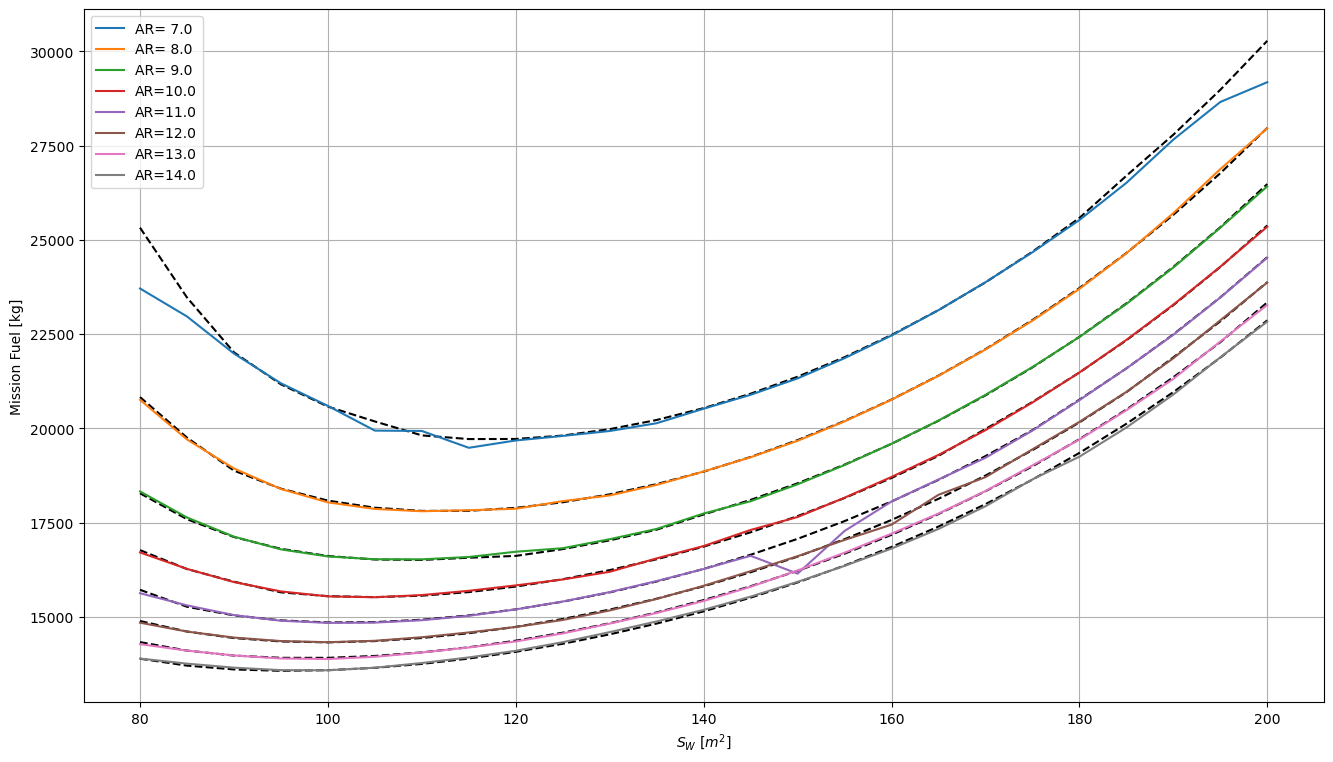

In [13]:
Y_PREDICT_norm = model.predict(X_VALID_norm)

Y_PREDICT = out_normalizer.denormalize(Y_PREDICT_norm)

XX = X_VALID[:,0].reshape((25,8))

YY = Y_PREDICT[:,0].reshape((25,8))

ARs = np.linspace(7,14,8)
AR_labels = ['AR={:4.1f}'.format(a) for a in ARs]

j = valid_cols.index('w_fuel')

Y_VALID = valid_data[:,j]

YY_V = Y_VALID.reshape((25,8))

fig,ax = plt.subplots(figsize=(16,9))
ax.plot(XX,YY_V, linestyle='--', color='k')
ax.plot(XX,YY, label=AR_labels)
ax.grid()
ax.set_xlabel('$S_W$ [$m^2$]')
ax.set_ylabel('Mission Fuel [kg]')
ax.legend()
plt.show()

In [14]:
YY_V

array([[25324.88602528, 20829.78698653, 18277.60263895, 16769.55950628,
        15716.53659692, 14888.6434423 , 14328.54578146, 13888.62049633],
       [23472.62128209, 19755.21261269, 17589.00740932, 16267.18666892,
        15266.47379579, 14609.16968823, 14103.76404089, 13705.09437096],
       [22017.13764896, 18879.00652475, 17116.64827042, 15931.956959  ,
        15037.75702106, 14436.21627709, 13971.58529594, 13603.59453954],
       [21167.84363654, 18399.89795185, 16803.71812098, 15648.45180041,
        14905.3458143 , 14345.87163301, 13911.87410925, 13566.84346825],
       [20577.51197844, 18083.4490495 , 16613.25395971, 15547.68596262,
        14850.04453305, 14322.38156977, 13911.41047886, 13583.53561966],
       [20183.48304962, 17894.69766569, 16520.56216659, 15522.0447717 ,
        14858.93721107, 14355.21973477, 13961.422789  , 13646.22331311],
       [19813.39081227, 17809.81798725, 16508.96072837, 15560.4746134 ,
        14923.34180729, 14437.38922597, 14056.14989858, 13